In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import gensim.downloader as api

# Data preparation (loading and preprocessing)

First of all we need to load our dataset (See `README.md` for details).

In [2]:
movies = pd.read_csv('../../data/ml-1m/movies.dat', sep='::', header=None, names=['movie_id', 'title', 'genres'], engine='python', encoding='latin-1')
ratings = pd.read_csv('../../data/ml-1m/ratings.dat', sep='::', header=None, names=['user_id', 'movie_id', 'rating', 'timestamp'], engine='python', encoding='latin-1')

In [3]:
movies.head()

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


Now let's merge both data frames and do a little of initial preprocessing

In [5]:
data = pd.merge(ratings, movies, on='movie_id')

In [6]:
data['genres'] = data['genres'].apply(lambda x: x.split('|'))
data['title'] = data['title'].str.replace(r'\(\d+\)', '').str.strip()
data['genres'] = data['genres'].apply(lambda x: ' '.join(x))
data.head()

,user_id,movie_id,rating,timestamp,title,genres
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama
1,2,1193,5,978298413,One Flew Over the Cuckoo's Nest (1975),Drama
2,12,1193,4,978220179,One Flew Over the Cuckoo's Nest (1975),Drama
3,15,1193,4,978199279,One Flew Over the Cuckoo's Nest (1975),Drama
4,17,1193,5,978158471,One Flew Over the Cuckoo's Nest (1975),Drama


To create features we will use TF-IDF.

Term Frequency-Inverse Document Frequency (TF-IDF) allow us to represent textual data as set of features.
It helps in identifying the importance of words in entire dataset.

Also it gives sparse representation that can be easily stored and efficient in computation even on large datasets.

In [7]:
# Running vectorizer on genres and titles.
vectorizer = TfidfVectorizer(max_features=1000)
tfidf_matrix = vectorizer.fit_transform(data['genres'] + ' ' + data['title'])

In [8]:
# Getting user profile based on average of TF-IDF vectors of movies he liked
user_profiles = data.groupby('user_id').apply(lambda x: np.mean(tfidf_matrix[x.index].toarray(), axis=0))

In [9]:
# Getting item profiles from TF-IDF vectors directly
item_profiles = tfidf_matrix.toarray()

In [10]:
scaler = MinMaxScaler()
user_profiles = scaler.fit_transform(user_profiles.tolist())
item_profiles = scaler.fit_transform(item_profiles)

In [11]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=5)

For this task decided to use PyTorch, so we should convert data to those tensors

In [12]:
train_user_profiles = torch.tensor(user_profiles[train_data['user_id'].values - 1], dtype=torch.float32)
train_item_profiles = torch.tensor(item_profiles[train_data['movie_id'].values - 1], dtype=torch.float32)
train_ratings = torch.tensor(train_data['rating'].values, dtype=torch.float32)

test_user_profiles = torch.tensor(user_profiles[test_data['user_id'].values - 1], dtype=torch.float32)
test_item_profiles = torch.tensor(item_profiles[test_data['movie_id'].values - 1], dtype=torch.float32)
test_ratings = torch.tensor(test_data['rating'].values, dtype=torch.float32)

Let's define baseline ContentBased filtering model using PyTorch

In [13]:
class ContentBasedModel(nn.Module):
    def __init__(self, input_dim):
        super(ContentBasedModel, self).__init__()
        self.fc1 = nn.Linear(input_dim * 2, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, user_profile, item_profile):
        x = torch.cat([user_profile, item_profile], dim=1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [14]:
input_dim = train_user_profiles.shape[1]
model = ContentBasedModel(input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [15]:
# Train model
num_epochs = 5
train_losses = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(train_user_profiles, train_item_profiles).squeeze()
    loss = criterion(outputs, train_ratings)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

Epoch 1/5, Loss: 14.792035102844238
Epoch 2/5, Loss: 14.057719230651855
Epoch 3/5, Loss: 13.378046035766602
Epoch 4/5, Loss: 12.706522941589355
Epoch 5/5, Loss: 12.023621559143066


Model evaluation

In [16]:
model.eval()
with torch.no_grad():
    test_outputs = model(test_user_profiles, test_item_profiles).squeeze()
    test_loss = mean_squared_error(test_ratings, test_outputs)
    print(f'Test MSE: {test_loss}')

Test MSE: 11.325066566467285


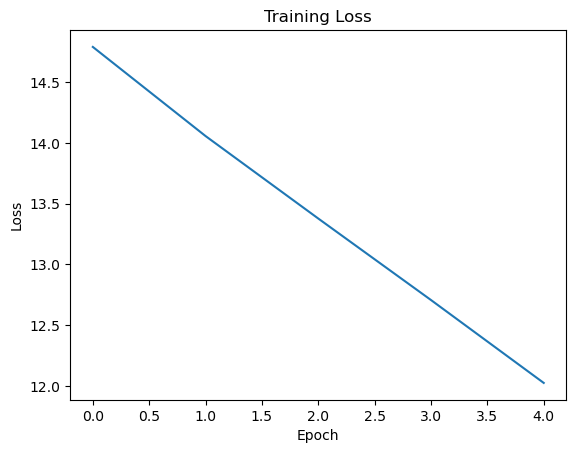

In [17]:
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In order to decrease losses, let's try some hyperparameter tuning.

We will adjust a model, to try it out with different parameters.

Testing learning rate: 0.001
Epoch 1/5, Loss: 14.07848072052002
Epoch 2/5, Loss: 13.333616256713867
Epoch 3/5, Loss: 12.623588562011719
Epoch 4/5, Loss: 11.888557434082031
Epoch 5/5, Loss: 11.140336036682129
Test MSE: 10.380576133728027
Testing learning rate: 0.005
Epoch 1/5, Loss: 14.627079010009766
Epoch 2/5, Loss: 11.061589241027832
Epoch 3/5, Loss: 7.748676300048828
Epoch 4/5, Loss: 4.666411399841309
Epoch 5/5, Loss: 2.322997808456421
Test MSE: 1.2530447244644165
Testing learning rate: 0.01
Epoch 1/5, Loss: 13.886075019836426
Epoch 2/5, Loss: 6.397992134094238
Epoch 3/5, Loss: 1.7314872741699219
Epoch 4/5, Loss: 2.5719566345214844
Epoch 5/5, Loss: 4.211396217346191
Test MSE: 2.866978645324707
Testing learning rate: 0.05
Epoch 1/5, Loss: 14.436832427978516
Epoch 2/5, Loss: 40.86580276489258
Epoch 3/5, Loss: 3.6329171657562256
Epoch 4/5, Loss: 13.320335388183594
Epoch 5/5, Loss: 13.82077407836914
Test MSE: 13.681974411010742
Testing learning rate: 0.1
Epoch 1/5, Loss: 14.568063735961

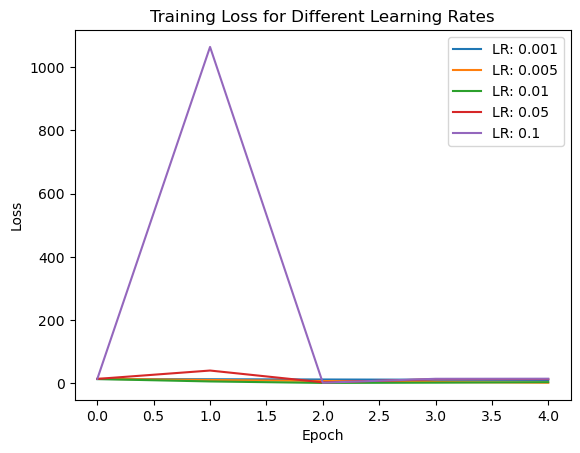

In [18]:
def train_and_evaluate(model, optimizer, num_epochs=5):
    train_losses = []
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(train_user_profiles, train_item_profiles).squeeze()
        loss = criterion(outputs, train_ratings)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

    model.eval()
    with torch.no_grad():
        test_outputs = model(test_user_profiles, test_item_profiles).squeeze()
        test_loss = mean_squared_error(test_ratings, test_outputs)
        print(f'Test MSE: {test_loss}')

    return train_losses, test_loss


learning_rates = [0.001, 0.005, 0.01, 0.05, 0.1]
for lr in learning_rates:
    print(f'Testing learning rate: {lr}')
    model = ContentBasedModel(input_dim)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_losses, test_loss = train_and_evaluate(model, optimizer)
    plt.plot(train_losses, label=f'LR: {lr}')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss for Different Learning Rates')
plt.legend()
plt.show()

So as we can see, best performing model is the model with learning rate 0.005 as a param.

- Before
Showed result a little bit worse
- After
Completly random and results are not benefit over epoch

In [19]:
model_lr_0005 = ContentBasedModel(input_dim)
optimizer = optim.Adam(model_lr_0005.parameters(), lr=0.005)
train_losses, test_loss = train_and_evaluate(model_lr_0005, optimizer)

Epoch 1/5, Loss: 13.530460357666016
Epoch 2/5, Loss: 9.869462013244629
Epoch 3/5, Loss: 6.599124431610107
Epoch 4/5, Loss: 3.7184927463531494
Epoch 5/5, Loss: 1.7644091844558716
Test MSE: 1.2566566467285156


In [20]:
print(f'Test MSE: {test_loss}')

Test MSE: 1.2566566467285156


Let's see feature importance

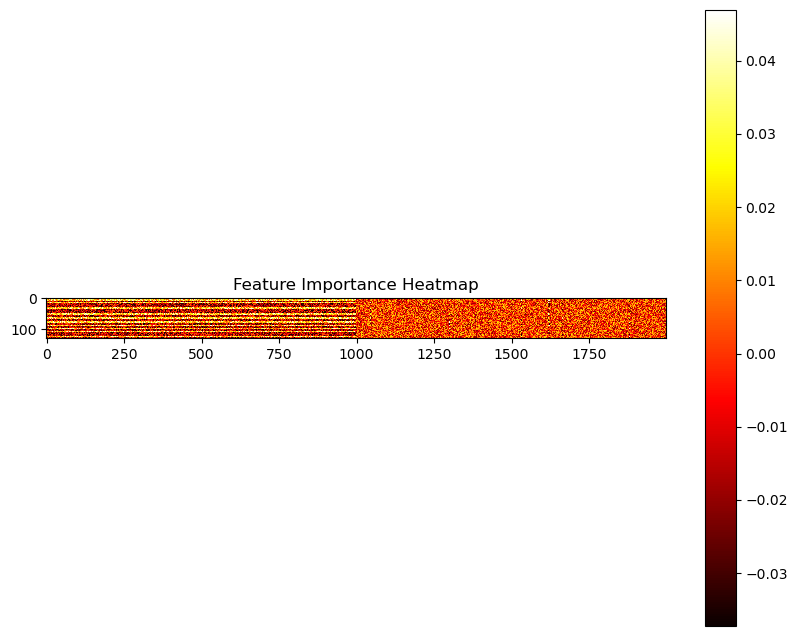

In [21]:
feature_importance = model_lr_0005.fc1.weight.data.numpy()
plt.figure(figsize=(10, 8))
plt.imshow(feature_importance, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Feature Importance Heatmap')
plt.show()

In order to try to make results better - let's try some additional methods in feature engineering

Let' enhance feature extraction process by using different techniques for embeddings.

I'll explore TF-IDF(as we already did) and word2vec

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

genre_vectorizer = TfidfVectorizer(max_features=500)
tfidf_genres = genre_vectorizer.fit_transform(data['genres'])

title_vectorizer = TfidfVectorizer(max_features=500)
tfidf_titles = title_vectorizer.fit_transform(data['title'])

tfidf_features = np.hstack((tfidf_genres.toarray(), tfidf_titles.toarray()))

scaler = MinMaxScaler()
item_profiles = scaler.fit_transform(tfidf_features)

user_profiles = data.groupby('user_id').apply(lambda x: np.mean(item_profiles[x.index], axis=0))
user_profiles = scaler.fit_transform(user_profiles.tolist())

train_user_profiles = torch.tensor(user_profiles[train_data['user_id'].values - 1], dtype=torch.float32)
train_item_profiles = torch.tensor(item_profiles[train_data['movie_id'].values - 1], dtype=torch.float32)
train_ratings = torch.tensor(train_data['rating'].values, dtype=torch.float32)

test_user_profiles = torch.tensor(user_profiles[test_data['user_id'].values - 1], dtype=torch.float32)
test_item_profiles = torch.tensor(item_profiles[test_data['movie_id'].values - 1], dtype=torch.float32)
test_ratings = torch.tensor(test_data['rating'].values, dtype=torch.float32)

In order to use embedding of word2vec we need to load pre-trained embeddings

In [23]:
import gensim.downloader as api

word2vec = api.load("glove-wiki-gigaword-50")


def get_embedding(text, model):
    words = text.split()
    word_vectors = [model[word] for word in words if word in model]
    if not word_vectors:
        return np.zeros(model.vector_size)
    return np.mean(word_vectors, axis=0)


data['genre_embeddings'] = data['genres'].apply(lambda x: get_embedding(x, word2vec))
data['title_embeddings'] = data['title'].apply(lambda x: get_embedding(x, word2vec))


embeddings = np.hstack((data['genre_embeddings'].values.tolist(), data['title_embeddings'].values.tolist()))


item_profiles = scaler.fit_transform(embeddings)


user_profiles = data.groupby('user_id').apply(lambda x: np.mean(item_profiles[x.index], axis=0))
user_profiles = scaler.fit_transform(user_profiles.tolist())


train_user_profiles = torch.tensor(user_profiles[train_data['user_id'].values - 1], dtype=torch.float32)
train_item_profiles = torch.tensor(item_profiles[train_data['movie_id'].values - 1], dtype=torch.float32)
train_ratings = torch.tensor(train_data['rating'].values, dtype=torch.float32)

test_user_profiles = torch.tensor(user_profiles[test_data['user_id'].values - 1], dtype=torch.float32)
test_item_profiles = torch.tensor(item_profiles[test_data['movie_id'].values - 1], dtype=torch.float32)
test_ratings = torch.tensor(test_data['rating'].values, dtype=torch.float32)

Since we are done with data pre-processing

Now let's try to define a different models

I would like to try two methods:
1. Make model with deeper network architecture
2. Add Dropout and Regularization

In [24]:
class DeeperContentBasedModel(nn.Module):
    def __init__(self, input_dim):
        super(DeeperContentBasedModel, self).__init__()
        self.fc1 = nn.Linear(input_dim * 2, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 1)

    def forward(self, user_profile, item_profile):
        x = torch.cat([user_profile, item_profile], dim=1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [25]:
input_dim = train_user_profiles.shape[1]
model = DeeperContentBasedModel(input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

train_losses, test_loss = train_and_evaluate(model, optimizer)

train_losses, test_loss

Epoch 1/5, Loss: 13.50428581237793
Epoch 2/5, Loss: 11.405794143676758
Epoch 3/5, Loss: 7.6496262550354
Epoch 4/5, Loss: 2.620396375656128
Epoch 5/5, Loss: 3.174877166748047
Test MSE: 3.7675740718841553


([13.50428581237793,
  11.405794143676758,
  7.6496262550354,
  2.620396375656128,
  3.174877166748047],
 3.767574)

In [26]:
class DropoutContentBasedModel(nn.Module):
    def __init__(self, input_dim):
        super(DropoutContentBasedModel, self).__init__()
        self.fc1 = nn.Linear(input_dim * 2, 256)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(128, 64)
        self.dropout3 = nn.Dropout(0.5)
        self.fc4 = nn.Linear(64, 1)

    def forward(self, user_profile, item_profile):
        x = torch.cat([user_profile, item_profile], dim=1)
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.relu(self.fc3(x))
        x = self.dropout3(x)
        x = self.fc4(x)
        return x

In [27]:
model = DropoutContentBasedModel(input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

train_losses, test_loss = train_and_evaluate(model, optimizer)

train_losses, test_loss

Epoch 1/5, Loss: 14.685155868530273
Epoch 2/5, Loss: 11.406264305114746
Epoch 3/5, Loss: 5.413318157196045
Epoch 4/5, Loss: 3.6702990531921387
Epoch 5/5, Loss: 4.026363372802734
Test MSE: 1.374039888381958


([14.685155868530273,
  11.406264305114746,
  5.413318157196045,
  3.6702990531921387,
  4.026363372802734],
 1.3740399)

Now let's evaluate all our models

Training Baseline Model
Epoch 1/5, Loss: 14.184264183044434
Epoch 2/5, Loss: 8.745484352111816
Epoch 3/5, Loss: 4.926062107086182
Epoch 4/5, Loss: 2.238898754119873
Epoch 5/5, Loss: 1.2702401876449585
Test MSE: 2.2071282863616943
Baseline Model Test MSE: 2.2071282863616943
Training Deeper Model
Epoch 1/5, Loss: 14.02298355102539
Epoch 2/5, Loss: 12.4016695022583
Epoch 3/5, Loss: 9.577799797058105
Epoch 4/5, Loss: 4.896396636962891
Epoch 5/5, Loss: 1.264653205871582
Test MSE: 7.684384346008301
Deeper Model Test MSE: 7.684384346008301
Training Dropout Model
Epoch 1/5, Loss: 13.323026657104492
Epoch 2/5, Loss: 10.486281394958496
Epoch 3/5, Loss: 5.3732171058654785
Epoch 4/5, Loss: 2.789177656173706
Epoch 5/5, Loss: 5.478694915771484
Test MSE: 1.2849793434143066
Dropout Model Test MSE: 1.2849793434143066


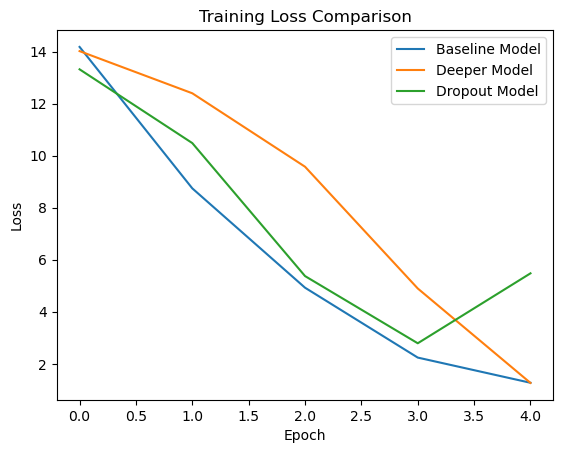

In [28]:
# Function to plot training losses for different models
def plot_train_losses(models, losses):
    for model_name, loss in losses.items():
        plt.plot(loss, label=model_name)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Comparison')
    plt.legend()
    plt.show()

# Train and evaluate different models
models = {
    'Baseline Model': ContentBasedModel(input_dim),
    'Deeper Model': DeeperContentBasedModel(input_dim),
    'Dropout Model': DropoutContentBasedModel(input_dim),
}

losses = {}
for model_name, model in models.items():
    print(f'Training {model_name}')
    optimizer = optim.Adam(model.parameters(), lr=0.005)
    train_losses, test_loss = train_and_evaluate(model, optimizer)
    losses[model_name] = train_losses
    print(f'{model_name} Test MSE: {test_loss}')

# Plot training losses
plot_train_losses(models, losses)

In [29]:
for model_name, test_loss in losses.items():
    print(f'{model_name} Test MSE: {test_loss}')

Baseline Model Test MSE: [14.184264183044434, 8.745484352111816, 4.926062107086182, 2.238898754119873, 1.2702401876449585]
Deeper Model Test MSE: [14.02298355102539, 12.4016695022583, 9.577799797058105, 4.896396636962891, 1.264653205871582]
Dropout Model Test MSE: [13.323026657104492, 10.486281394958496, 5.3732171058654785, 2.789177656173706, 5.478694915771484]


In [33]:
model = DropoutContentBasedModel(input_dim)
optimizer = optim.Adam(model.parameters(), lr=0.005)
train_losses, test_loss = train_and_evaluate(model, optimizer)

Epoch 1/5, Loss: 13.259490013122559
Epoch 2/5, Loss: 10.668208122253418
Epoch 3/5, Loss: 5.744115829467773
Epoch 4/5, Loss: 2.466689348220825
Epoch 5/5, Loss: 6.864243984222412
Test MSE: 1.359695553779602


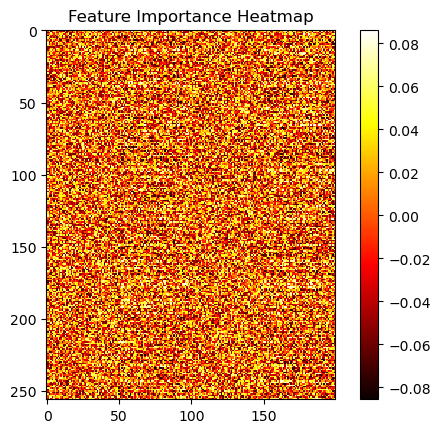

In [34]:
feature_importance = model.fc1.weight.data.numpy()
plt.imshow(feature_importance, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Feature Importance Heatmap')
plt.show()

## Resuts

In this experiment we tried several different models and feature extraction/data preparation technics 

Based on the result i can clearly see that best performed model is - model with dropout and regularization with final Test MSE = 1.28

Overwise making more deeper architecrure are not helped at all, and quite an opposite make results worse on test set.

Also making separate TF-IDF vectors with word2vec envolved resulted into better result even on baseline model. 

My propose to stick with DropoutModel and TF-IDF + word2vec data preparation.

My main consern is about data itself, it seems that title and genre is not enougth to this model.

Futher we should find dataset with small descriptions for those movies, maybe critics reports and some community reviews. This data should make results more robust in general.